# Generate model waveform

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from pwca import *
from glob import glob

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"


In [2]:
# Display basic info about calibration runs
scsearch( catalog=pwca_catalog, verbose=True );

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found verbose (=True) keyword.
## Found 40 possibly degenerate simulations:
[0001][hogshead] q8precessing: 1chi0.80-p-q8.00	(q8a08t120dP2_r03_T_96_360)
[0002][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t60D_dPm1)
[0003][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t90dPm1D_T_96_384)
[0004][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t120dPp1_T_96_360)
[0005][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t90dP0_T_96_360)
[0006][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th150)
[0007][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th120)
[0008][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th90)
[0009][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th60)
[0010][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th30)
[0011][hogshead] q8: 1chi0.80-p-q8.00	(q8a08t90dP0_T_96_384)
[0012][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t30dPm5p5dRm4

In [59]:
# Load select simulation data
a = scsearch( catalog=pwca_catalog, keyword='q1a08t30dPm25_T_96_408', verbose=True )[0]

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q1a08t30dPm25_T_96_408) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][hogshead] q1: 1chi0.80-p-q1.00	(q1a08t30dPm25_T_96_408)



In [60]:
# Load select waveforms
files = glob( datadir+'q*.txt' )
simnames = [ f_.split('/')[-1].split('.')[0] for f_ in files ]
# Find index corresponding to chosen case
k = simnames.index( a.simname )
# Load data for this case
raw_data = loadtxt(files[k]).T
data,_,fmin,fmax,fknot = determine_data_fitting_region(raw_data)

In [61]:
# Define data location
datadir = '/Users/book/KOALA/puck/ll/data/version2/'
# Load and unpuack OPTIMAL physical parameter space -- dphi
dphi_range = loadtxt(datadir+'fit_opt_dphase_parameters.txt')
opt_nu4,opt_nu5,opt_nu6 = dphi_range[k,:]
# Load and unpuack OPTIMAL physical parameter space -- amp
amp_range = loadtxt(datadir+'fit_opt_amplitude_parameters.txt')
opt_mu1, opt_mu2, opt_mu3, opt_mu4 = amp_range[k,:]

In [82]:
# extract useful params from scentry object
theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2 = select_scenty_metadata(a)
# generate model parameters 
mu1,mu2,mu3,mu4,nu4,nu5,nu6 = generate_model_params(theta,eta,chi_eff,chi_p)

In [83]:
# generate template functions
template_amp  = template_amp_mrd(  m1, m2, chi1, chi2, chi_p )
template_dphi = template_dphi_mrd( m1, m2, chi1, chi2, chi_p )

In [84]:
# Load and unpuack physical parameter space
raw_domain = loadtxt(datadir+'fit_intial_binary_parameters.txt')
print raw_domain[k,:]
print array([theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2])
print sum(raw_domain[k,:]-array([theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2]))==0

[3.00287557e+01 5.00004500e-01 4.99995500e-01 2.50000000e-01
 8.99991900e-06 3.46300683e-01 4.00333588e-01 6.92595133e-01
 0.00000000e+00]
[3.00287557e+01 5.00004500e-01 4.99995500e-01 2.50000000e-01
 8.99991900e-06 3.46300683e-01 4.00333588e-01 6.92595133e-01
 0.00000000e+00]
True


In [85]:
print opt_nu4, opt_nu5, opt_nu6
print nu4,nu5,nu6

-0.07055194546311169 -0.030509052449450468 0.001537826724147738
-0.06850688570539859 -0.029139940316258633 0.0015962395164250969


(6.938893903907228e-18, 0.1588475764064629)

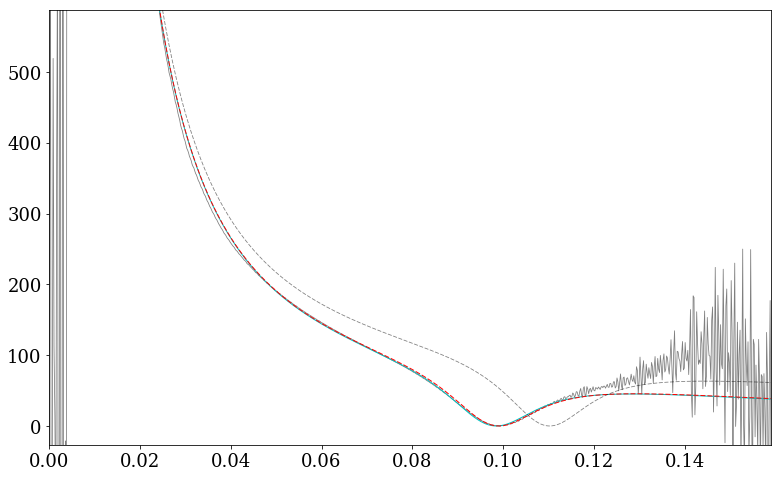

In [90]:

#
raw_f,raw_amp_td,raw_amp_fd,raw_dphi_td,raw_dphi_fd = raw_data
adjusted_raw_dphi_td = raw_dphi_td-min( raw_dphi_td[ (raw_f>=fmin) & (raw_f<=fmax)  ])
f,amp_td,amp_fd,dphi_td,dphi_fd = data.T

#
raw_positive_mask = raw_f>0
raw_fp = raw_f[raw_positive_mask]

#
phenomd_dphi   = template_dphi( raw_fp )
opt_model_dphi = template_dphi( raw_fp, opt_nu4, opt_nu5, opt_nu6 )
model_dphi     = template_dphi( raw_fp, nu4, nu5, nu6 )

#
figure( figsize=2*figaspect(0.618) )

#
plot( raw_f, adjusted_raw_dphi_td, label='raw symmetrized NR', color='k', alpha=0.5 )
#
plot( raw_fp, opt_model_dphi, ls='-', color='c', lw=1 )
plot( raw_fp, model_dphi, ls='--', color='r', lw=1 )
plot( raw_fp, phenomd_dphi, color='k', ls='--', alpha=0.5 )

ylim(lim(dphi_td,dilate=0.1)+array([0,300]))
xlim(lim(f,dilate=0.5))


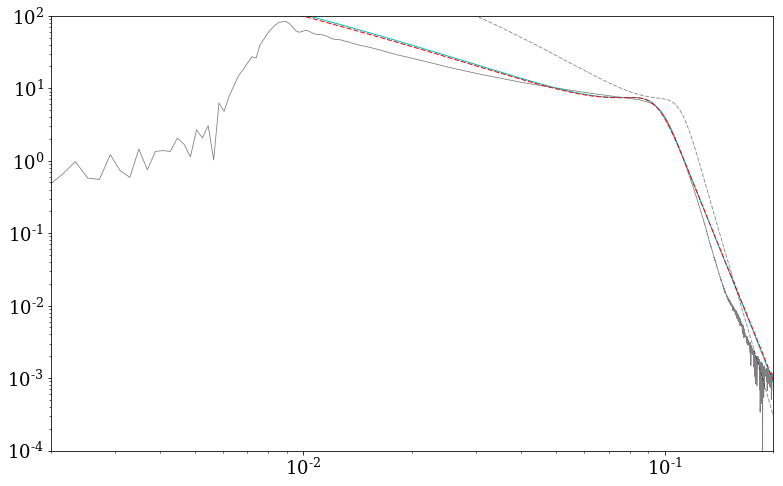

In [101]:

#
raw_f,raw_amp_td,raw_amp_fd,raw_dphi_td,raw_dphi_fd = raw_data
f,amp_td,amp_fd,dphi_td,dphi_fd = data.T

#
raw_positive_mask = raw_f>0
raw_fp = raw_f[raw_positive_mask]

#
scale_factor = raw_fp ** (-7.0/6.0)
phenomd_amp   = exp( template_amp( raw_fp ) ) * scale_factor
opt_model_amp = exp( template_amp( raw_fp, opt_mu1, opt_mu2, opt_mu3, opt_mu4 ) ) * scale_factor
model_amp     = exp( template_amp( raw_fp, mu1, mu2, mu3, mu4 ) ) * scale_factor

#
figure( figsize=2*figaspect(0.618) )

#
plot( raw_f, raw_amp_fd, label='raw symmetrized NR', color='k', alpha=0.5 )
#
plot( raw_fp, opt_model_amp, ls='-', color='c', lw=1 )
plot( raw_fp, model_amp, ls='--', color='r', lw=1 )
plot( raw_fp, phenomd_amp, color='k', ls='--', alpha=0.5 )

ylim( 1e-4, 1e2 )
xlim(0.002,0.2)

xscale('log')
yscale('log')

